In [ ]:
import requests
import pandas as pd

# collecting DMO gilt announcements from 2005 to present

url = 'https://www.dmo.gov.uk/publications/?offset=0&itemsPerPage=1000000&parentFilter=1433&childFilter=1433|1450&startMonth=1&startYear=2005&endMonth=7&endYear=2021'
html = requests.get(url).content
df_list = pd.read_html(html)
dates = df_list[-1]
dates.to_excel('gilt_announcements_20052021.xlsx')


In [2]:
import pandas as pd

dates = pd.read_excel('gilt_announcements_20052021.xlsx')

In [3]:
exchange_rates = pd.read_csv('exchangerates.xlsm - ObservationData (1).csv')
exchange_rates = exchange_rates.T
new_header = exchange_rates.iloc[0] #grab the first row for the header
exchange_rates = exchange_rates[1:] #take the data less the header row
exchange_rates.columns = new_header
exchange_rates = exchange_rates.reset_index()
exchange_rates['index'] = pd.to_datetime(exchange_rates['index'] )
exchange_rates['Date'] = exchange_rates['index'].copy()
del exchange_rates['index']

In [4]:
ftse = pd.read_csv('ftse100close.csv').T
ftse = ftse[1:]
ftse = ftse.reset_index()
ftse.columns = ['Date','close']
ftse['close'] = ftse['close'].str.replace(',','.')
ftse = ftse.dropna()
ftse['close'] = pd.to_numeric(ftse['close'])
ftse['Date'] = pd.to_datetime(ftse['Date'],infer_datetime_format=True)

In [5]:
dates = dates.dropna()
dates = dates[dates['Publication title'].str.contains("Treasury Gilt")]
dates = dates[~dates['Publication title'].str.contains("Result")]
dates['amount'] = dates['Publication title'].str.split('Auction of ').str[1]
dates['amount2'] = dates['Publication title'].str.split('Auctions of ').str[1]
dates.loc[dates['amount'].isnull(), 'amount'] = dates['amount2']
dates['amount'] = dates['amount'].str.split('of').str[0]
dates.loc[dates['Publication title'].str.contains("Index"), 'index'] = 1
dates.loc[~dates['Publication title'].str.contains("Index"), 'index'] = 0
dates.amount.replace('\D+','',regex=True,inplace=True)
del dates['amount2']
dates = dates.dropna()
dates['Date published'] = pd.to_datetime(dates['Date published'],infer_datetime_format=True)

In [6]:
dates = pd.read_excel('datescheck4.xlsx')

In [7]:
spot_infla_2005 = pd.read_excel('Inflation_Daily_2005-2015.xlsx', '4')
spot_infla_2005 = spot_infla_2005.dropna()
spot_infla_pres = pd.read_excel('2016-present_infla.xlsx', '4')
spot_infla_pres = spot_infla_pres.dropna()

In [8]:
implied_infla = pd.concat([spot_infla_2005,spot_infla_pres])
implied_infla = implied_infla.dropna(axis = 1)
implied_infla.columns

Index(['Date',    2.5,      3,    3.5,      4,    4.5,      5,    5.5,      6,
          6.5,      7,    7.5,      8,    8.5,      9,    9.5,     10,   10.5,
           11,   11.5,     12,   12.5,     13,   13.5,     14,   14.5,     15,
         15.5,     16,   16.5,     17,   17.5,     18,   18.5,     19,   19.5,
           20,   20.5,     21,   21.5,     22,   22.5,     23,   23.5,     24,
         24.5,     25],
      dtype='object')

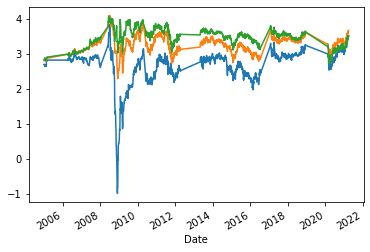

In [9]:
implied_infla = implied_infla.set_index('Date')
# 5 year bonds
implied_infla[5].plot()

# 10 year bonds
implied_infla[15].plot()


implied_infla[25].plot()

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
implied_infla = implied_infla.reset_index()
implied_infla = pd.merge(implied_infla, exchange_rates, on='Date')
implied_infla['Exchange Index'] = implied_infla['Exchange Index'].str.replace(r',', r'.').astype('float') 
implied_infla['Exchange Index'] = pd.to_numeric(implied_infla['Exchange Index'])


implied_infla = implied_infla.reset_index()
implied_infla = pd.merge(implied_infla, ftse, on='Date')
implied_infla['close'] = pd.to_numeric(implied_infla['close'])
implied_infla['close_pctchange'] = implied_infla['close'].pct_change()



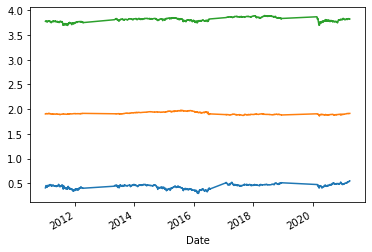

In [12]:
import numpy as np

implied_infla = implied_infla.set_index('Date')


np.log10(implied_infla[5]).plot()
np.log10(implied_infla['Exchange Index']).plot()
np.log10(implied_infla['close']).plot()

In [13]:
dates = dates[dates['Date published'] <= '2021-03-31']
dates = dates[dates['Date published'] >= '2011-01-04']

dates['amount'] = pd.to_numeric(dates['amount'])

In [ ]:
a = implied_infla.corr()
a.to_excel('correlation_matrix.xlsx')

In [14]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from dateutil.relativedelta import relativedelta

dates['pre_period'] = dates['Date published'] - pd.DateOffset(days=20)
dates['post_period'] = dates['Date published'] + pd.DateOffset(days=3)
dates['datepublished1'] = dates['Date published'] + pd.DateOffset(days=1)

from pandas.tseries.offsets import BDay
dates.pre_period = dates.pre_period.map(lambda x : x + 0*BDay())
dates.post_period = dates.post_period.map(lambda x : x + 0*BDay())
dates.datepublished1 = dates.datepublished1.map(lambda x : x + 0*BDay())
dates['Date published'] = dates['Date published'].map(lambda x : x + 0*BDay())


dates = dates[dates['post_period'] <= '2021-03-31']
dates = dates[dates['pre_period'] >= '2011-01-04']

dates = dates.sort_values(by=['Date published'])

implied_infla = implied_infla.reset_index()
a = dates['Date published'].tolist()
b = dates['pre_period'].tolist()
c = dates['post_period'].tolist()
d = dates['datepublished1'].tolist()

implied_infla['Date'] = pd.to_datetime(implied_infla['Date'],infer_datetime_format=True)
implied_infla = implied_infla[implied_infla['Date'] <= '2021-03-31']
implied_infla = implied_infla[implied_infla['Date'] >= '2011-01-04']
implied_infla = implied_infla.set_index("Date")

implied_infla.columns = [str(col) + '_year' for col in implied_infla.columns]
implied_infla.columns

Index(['index_year', '2.5_year', '3_year', '3.5_year', '4_year', '4.5_year',
       '5_year', '5.5_year', '6_year', '6.5_year', '7_year', '7.5_year',
       '8_year', '8.5_year', '9_year', '9.5_year', '10_year', '10.5_year',
       '11_year', '11.5_year', '12_year', '12.5_year', '13_year', '13.5_year',
       '14_year', '14.5_year', '15_year', '15.5_year', '16_year', '16.5_year',
       '17_year', '17.5_year', '18_year', '18.5_year', '19_year', '19.5_year',
       '20_year', '20.5_year', '21_year', '21.5_year', '22_year', '22.5_year',
       '23_year', '23.5_year', '24_year', '24.5_year', '25_year',
       'Exchange Index_year', 'close_year', 'close_pctchange_year'],
      dtype='object')

In [ ]:
implied_infla.columns

In [15]:
year3 = implied_infla[['3_year','25_year','Exchange Index_year', 'close_year']]
year4 = implied_infla[['4_year','25_year','Exchange Index_year', 'close_year']]
year5 = implied_infla[['5_year','25_year','Exchange Index_year', 'close_year']]
year6 = implied_infla[['6_year','25_year','Exchange Index_year', 'close_year']]
year7 = implied_infla[['7_year','25_year','Exchange Index_year', 'close_year']]
year8 = implied_infla[['8_year','25_year','Exchange Index_year', 'close_year']]
year9 = implied_infla[['9_year','25_year','Exchange Index_year', 'close_year']]
year10 = implied_infla[['10_year','25_year','Exchange Index_year', 'close_year']]
year11 = implied_infla[['11_year','25_year','Exchange Index_year', 'close_year']]
year12 = implied_infla[['12_year','25_year','Exchange Index_year', 'close_year']]
year13 = implied_infla[['13_year','25_year','Exchange Index_year', 'close_year']]
year14 = implied_infla[['14_year','25_year','Exchange Index_year', 'close_year']]
year15 = implied_infla[['15_year','25_year','Exchange Index_year', 'close_year']]

list_years = [year3,year4,year5,year6,year7,year8,year9,year10,
             year11,year12,year13,year14,year15]

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
import re
import warnings
warnings.filterwarnings('ignore')

res = dates[['Date published','pre_period', 'post_period','amount', 'index']]

for x in range(0, len(list_years)):
    print(list_years[x].columns[0])
    
    params = []
    errors = []
    list2 = []
    data = list_years[x].copy()
    data.columns = ['y', 'X1', 'X2', 'X3']
    
    for n in range(0,len(dates)):
        pre_period = [b[n], a[n]]
        post_period = [d[n], c[n]]
        try:
            ci = CausalImpact(data, pre_period, post_period)
            r1 = re.search('tail-area probability p: (.+?)\nPosterior prob.', ci.summary())
            params.append(r1.group(1))
            list2.append(ci.summary())

        except ValueError as err:
            params.append('NaN')
            errors.append(err)
            list2.append('error')
            pass
    
    try:
        print(len(params))
        print('sig numbers:', len([float(n) for n in params if float(n) <= 0.05]))
        print('non-sig numbers:', len([float(n) for n in params if float(n) > 0.05]))
        print(len(errors))
    except TypeError:
        print('weird')
    
    listtemp = []
    for num in range(0, len(list2)):
        try:
            actual_average = re.search('\nActual[\t ]*(.+?)[\t ]', list2[num]).group(1)
            actual_cumulative = re.search('\nActual[\t ]*\d.\d*[\t ]*(.+?)\nPrediction', list2[num]).group(1)

            rel_average = re.search('\n\nRelative effect \(s.d.\)[\t ]*(.+?)\s', list2[num]).group(1)
            rel_cumulative = re.search('\n\nRelative effect \(s.d.\).*-.*\)[\t ]*(.+?)\s', list2[num]).group(1)

            abs_average = re.search('\nAbsolute effect \(s.d.\)[\t ]*(.+?)\s', list2[num]).group(1)
            abs_cumulative = re.search('\nAbsolute effect \(s.d.\).*-.*\)[\t ]*(.+?)\s', list2[num]).group(1)

            listtemp.append([actual_average,actual_cumulative,rel_average,rel_cumulative,abs_average,abs_cumulative])
        
        except:
            listtemp.append(['error','error','error','error','error','error'])
            
    if x == 0:
        res['year3_p-value'] = params
        
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year3' for col in dtemp.columns]
        
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
        
    elif x == 1:
        res['year4_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year4' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
        
    elif x == 2:
        res['year5_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year5' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
    elif x == 3:
        res['year6_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year6' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
        
    elif x == 4:
        res['year7_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year7' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
    elif x == 5:
        res['year8_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year8' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
    elif x == 6:
        res['year9_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year9' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
    elif x == 7:
        res['year10_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year10' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
    
    elif x == 8:
        res['year11_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year11' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
        
    elif x == 9:
        res['year12_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year12' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
        
    elif x == 10:
        res['year13_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year13' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)
    
    elif x == 11:
        res['year14_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year14' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)   
        
    elif x == 12:
        res['year15_p-value'] = params
        dtemp = pd.DataFrame.from_records(listtemp, columns =['actual_average','actual_cumulative','rel_average',
                                                              'rel_cumulative','abs_average','abs_cumulative'])
        dtemp.columns = [str(col) + 'year15' for col in dtemp.columns]
        res = pd.concat([res.reset_index(drop=True),dtemp.reset_index(drop=True)], axis=1)        

In [16]:
import pandas as pd

res = pd.read_excel('finall2.xlsx')

In [423]:
res.to_excel('check5.xlsx')

In [17]:
dates['amount2'] = dates['amount'].copy()
del dates['amount']

dates1 = dates[['Date published','amount2']]

res = res.merge(dates1, on='Date published')

In [ ]:
x = 530
n = 2
data = list_years[n].copy()
pre_period = [b[x], a[x]]
post_period = [d[x], c[x]]
ci = CausalImpact(data, pre_period, post_period)

In [ ]:
print(ci.summary())

In [ ]:
ci.plot()

In [ ]:
pd.options.display.max_colwidth = 1000

In [26]:
res3year = res[['Date published', 'pre_period', 'post_period','amount', 'index','year3_p-value', 
             'actual_averageyear3', 'actual_cumulativeyear3',
             'rel_averageyear3', 'rel_cumulativeyear3', 'abs_averageyear3','abs_cumulativeyear3']]
res4year = res[['Date published', 'pre_period', 'post_period','amount', 'index','year4_p-value', 
             'actual_averageyear4', 'actual_cumulativeyear4',
             'rel_averageyear4', 'rel_cumulativeyear4', 'abs_averageyear4','abs_cumulativeyear4']]
res5year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
             'year5_p-value', 'actual_averageyear5',
       'actual_cumulativeyear5', 'rel_averageyear5', 'rel_cumulativeyear5',
       'abs_averageyear5', 'abs_cumulativeyear5']]
res6year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
                'year6_p-value', 
             'actual_averageyear6', 'actual_cumulativeyear6',
             'rel_averageyear6', 'rel_cumulativeyear6', 'abs_averageyear6','abs_cumulativeyear6']]
res7year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
             'year7_p-value','actual_averageyear7', 'actual_cumulativeyear7', 'rel_averageyear7',
       'rel_cumulativeyear7', 'abs_averageyear7', 'abs_cumulativeyear7']]
res8year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
             'year8_p-value','actual_averageyear8', 'actual_cumulativeyear8', 'rel_averageyear8',
       'rel_cumulativeyear8', 'abs_averageyear8', 'abs_cumulativeyear8']]
res9year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
             'year9_p-value','actual_averageyear9', 'actual_cumulativeyear9', 'rel_averageyear9',
       'rel_cumulativeyear9', 'abs_averageyear9', 'abs_cumulativeyear9']]
res10year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
              'year10_p-value', 'actual_averageyear10', 'actual_cumulativeyear10',
       'rel_averageyear10', 'rel_cumulativeyear10', 'abs_averageyear10',
       'abs_cumulativeyear10']]
res11year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
              'year11_p-value', 'actual_averageyear11', 'actual_cumulativeyear11',
       'rel_averageyear11', 'rel_cumulativeyear11', 'abs_averageyear11',
       'abs_cumulativeyear11']]
res12year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
              'year12_p-value', 'actual_averageyear12', 'actual_cumulativeyear12',
       'rel_averageyear12', 'rel_cumulativeyear12', 'abs_averageyear12',
       'abs_cumulativeyear12']]
res13year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
              'year13_p-value', 'actual_averageyear13', 'actual_cumulativeyear13',
       'rel_averageyear13', 'rel_cumulativeyear13', 'abs_averageyear13',
       'abs_cumulativeyear13']]
res14year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
              'year14_p-value', 'actual_averageyear14', 'actual_cumulativeyear14',
       'rel_averageyear14', 'rel_cumulativeyear14', 'abs_averageyear14',
       'abs_cumulativeyear14']]
res15year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
              'year15_p-value', 'actual_averageyear15', 'actual_cumulativeyear15',
       'rel_averageyear15', 'rel_cumulativeyear15', 'abs_averageyear15',
       'abs_cumulativeyear15']]

In [27]:
import pickle

with open("list1finally.txt", "rb") as fp:   # Unpickling
    data = pickle.load(fp)

#listdf = pd.DataFrame.from_records(data)

listdf = pd.read_excel('listdf3.xlsx')
listdf['Date published'] = pd.to_datetime(listdf['Date published'])
listdf.columns = ['Date published', 'avg_auction_value', 'supposed_auction_value_todate', 'total_sales_todate',
                             'total_auctions_planned','total_auctions_remaining','total_planned_sales','total_sales_remaining']

In [28]:
res3year = res[['Date published', 'pre_period', 'post_period','amount', 'index','year3_p-value', 
             'actual_averageyear3', 'actual_cumulativeyear3',
             'rel_averageyear3', 'rel_cumulativeyear3', 'abs_averageyear3','abs_cumulativeyear3']]

res3year = res3year[~res3year['actual_averageyear3'].str.contains("error")]
res3year = res3year.dropna(subset = ['year3_p-value'])
res3year['rel_cumulativeyear3'] = res3year['rel_cumulativeyear3'].str.replace(r'%', r'').astype('float') / 100.0
res3year['rel_averageyear3'] = res3year['rel_averageyear3'].str.replace(r'%', r'').astype('float') / 100.0
res3year['actual_cumulativeyear3'] = pd.to_numeric(res3year['actual_cumulativeyear3'])
res3year['actual_averageyear3'] = pd.to_numeric(res3year['actual_averageyear3'])
res3year['abs_cumulativeyear3'] = pd.to_numeric(res3year['abs_cumulativeyear3'])
res3year['abs_averageyear3'] = pd.to_numeric(res3year['abs_averageyear3'])
res3year['year3_p-value'] = pd.to_numeric(res3year['year3_p-value'])
res3year['sig'] = 1
res3year.loc[res3year['year3_p-value'] > 0.05, 'sig'] = 0

df1 = res3year.merge(listdf, on='Date published')
df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear3'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())


adaptive Ttest_indResult(statistic=-1.8154888374297797, pvalue=0.07068649225336192)
naive Ttest_indResult(statistic=-1.7858263897248128, pvalue=0.07537945772717075)
 

mean of relative effect:  -0.02883064516129034
 

mean of surprise of non-significant gilt announcements:  -6702.877181574675
mean of surprise of significant gilt announcements:  -4980.282477882074
 

number of significant: 186
number of non-significant: 58
 



1.3458829316093643

In [29]:
res4year = res[['Date published', 'pre_period', 'post_period','amount', 'index','year4_p-value', 
             'actual_averageyear4', 'actual_cumulativeyear4',
             'rel_averageyear4', 'rel_cumulativeyear4', 'abs_averageyear4','abs_cumulativeyear4']]
res4year = res4year[~res4year['actual_averageyear4'].str.contains("error")]
res4year = res4year.dropna(subset = ['year4_p-value'])

res4year['rel_cumulativeyear4'] = res4year['rel_cumulativeyear4'].str.replace(r'%', r'').astype('float') / 100.0
res4year['rel_averageyear4'] = res4year['rel_averageyear4'].str.replace(r'%', r'').astype('float') / 100.0
res4year['actual_cumulativeyear4'] = pd.to_numeric(res4year['actual_cumulativeyear4'])
res4year['actual_averageyear4'] = pd.to_numeric(res4year['actual_averageyear4'])
res4year['abs_cumulativeyear4'] = pd.to_numeric(res4year['abs_cumulativeyear4'])
res4year['abs_averageyear4'] = pd.to_numeric(res4year['abs_averageyear4'])

res4year['year4_p-value'] = pd.to_numeric(res4year['year4_p-value'])
res4year['sig'] = 1
res4year.loc[res4year['year4_p-value'] > 0.05, 'sig'] = 0

df1 = res4year.merge(listdf, on='Date published')

df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear4'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

adaptive Ttest_indResult(statistic=-2.9354924017702304, pvalue=0.003656314859253598)
naive Ttest_indResult(statistic=-3.2229908566999588, pvalue=0.001446062619029673)
 

mean of relative effect:  -0.02666023391812863
 

mean of surprise of non-significant gilt announcements:  -7793.0812030960515
mean of surprise of significant gilt announcements:  -4788.090312556655
 

number of significant: 171
number of non-significant: 69
 



1.6275969529352607

In [30]:
res5year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
             'year5_p-value', 'actual_averageyear5',
       'actual_cumulativeyear5', 'rel_averageyear5', 'rel_cumulativeyear5',
       'abs_averageyear5', 'abs_cumulativeyear5']]

res5year = res5year[~res5year['actual_averageyear5'].str.contains("error")]
res5year = res5year.dropna(subset = ['year5_p-value'])
res5year['rel_cumulativeyear5'] = res5year['rel_cumulativeyear5'].str.replace(r'%', r'').astype('float') / 100.0
res5year['rel_averageyear5'] = res5year['rel_averageyear5'].str.replace(r'%', r'').astype('float') / 100.0
res5year['actual_cumulativeyear5'] = pd.to_numeric(res5year['actual_cumulativeyear5'])
res5year['actual_averageyear5'] = pd.to_numeric(res5year['actual_averageyear5'])
res5year['abs_cumulativeyear5'] = pd.to_numeric(res5year['abs_cumulativeyear5'])
res5year['abs_averageyear5'] = pd.to_numeric(res5year['abs_averageyear5'])
res5year['year5_p-value'] = pd.to_numeric(res5year['year5_p-value'])
res5year['sig'] = 1
res5year.loc[res5year['year5_p-value'] > 0.05, 'sig'] = 0

df1 = res5year.merge(listdf, on='Date published')

df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear5'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

adaptive Ttest_indResult(statistic=-3.593472531784745, pvalue=0.00039099981523742835)
naive Ttest_indResult(statistic=-4.141072723494167, pvalue=4.6923701757955577e-05)
 

mean of relative effect:  -0.022294329896907192
 

mean of surprise of non-significant gilt announcements:  -8991.416698739658
mean of surprise of significant gilt announcements:  -5111.642502409224
 

number of significant: 194
number of non-significant: 65
 



1.75900734343253

In [31]:
res6year = res[['Date published', 'pre_period', 'post_period','amount', 'index',
                'year6_p-value', 
             'actual_averageyear6', 'actual_cumulativeyear6',
             'rel_averageyear6', 'rel_cumulativeyear6', 'abs_averageyear6','abs_cumulativeyear6']]
res6year = res6year[~res6year['actual_averageyear6'].str.contains("error")]
res6year = res6year.dropna(subset = ['year6_p-value'])

res6year['rel_cumulativeyear6'] = res6year['rel_cumulativeyear6'].str.replace(r'%', r'').astype('float') / 100.0
res6year['rel_averageyear6'] = res6year['rel_averageyear6'].str.replace(r'%', r'').astype('float') / 100.0
res6year['actual_cumulativeyear6'] = pd.to_numeric(res6year['actual_cumulativeyear6'])
res6year['actual_averageyear6'] = pd.to_numeric(res6year['actual_averageyear6'])
res6year['abs_cumulativeyear6'] = pd.to_numeric(res6year['abs_cumulativeyear6'])
res6year['abs_averageyear6'] = pd.to_numeric(res6year['abs_averageyear6'])

res6year['year6_p-value'] = pd.to_numeric(res6year['year6_p-value'])
res6year['sig'] = 1
res6year.loc[res6year['year6_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res6year[res6year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res6year[res6year['sig'] == 1]['amount'].mean())

df1 = res6year.merge(listdf, on='Date published')

df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear6'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2238.0
mean of significant gilt announcements:  251578087.0880503
adaptive Ttest_indResult(statistic=-4.8617093623946515, pvalue=2.0120542334094736e-06)
naive Ttest_indResult(statistic=-5.092548112142692, pvalue=6.774968721835755e-07)
 

mean of relative effect:  -0.018892417061611388
 

mean of surprise of non-significant gilt announcements:  -10516.2470317321
mean of surprise of significant gilt announcements:  -5413.10378114426
 

number of significant: 211
number of non-significant: 52
 



1.9427388531444525

In [32]:
res7year = res7year[~res7year['actual_averageyear7'].str.contains("error")]
res7year = res7year.dropna(subset = ['year7_p-value'])

res7year['rel_cumulativeyear7'] = res7year['rel_cumulativeyear7'].str.replace(r'%', r'').astype('float') / 100.0
res7year['rel_averageyear7'] = res7year['rel_averageyear7'].str.replace(r'%', r'').astype('float') / 100.0
res7year['actual_cumulativeyear7'] = pd.to_numeric(res7year['actual_cumulativeyear7'])
res7year['actual_averageyear7'] = pd.to_numeric(res7year['actual_averageyear7'])
res7year['abs_cumulativeyear7'] = pd.to_numeric(res7year['abs_cumulativeyear7'])
res7year['abs_averageyear7'] = pd.to_numeric(res7year['abs_averageyear7'])

res7year['year7_p-value'] = pd.to_numeric(res7year['year7_p-value'])
res7year['sig'] = 1
res7year.loc[res7year['year7_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res7year[res7year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res7year[res7year['sig'] == 1]['amount'].mean())

df1 = res7year.merge(listdf, on='Date published')

df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/df1['total_auctions_remaining']
df1['surprise'] = df1['amount'] - df1['auctions_value_remaining']
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']

df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear7'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2174.21875
mean of significant gilt announcements:  254782871.63694268
adaptive Ttest_indResult(statistic=-3.760558260325888, pvalue=0.00020787840449858257)
naive Ttest_indResult(statistic=-4.024010267009641, pvalue=7.435275943726547e-05)
 

mean of relative effect:  -0.017495192307692323
 

mean of surprise of non-significant gilt announcements:  -9234.402017482871
mean of surprise of significant gilt announcements:  -5483.665667293502
 

number of significant: 208
number of non-significant: 64
 



1.6839834114176708

In [33]:
res8year = res8year[~res8year['actual_averageyear8'].str.contains("error")]
res8year = res8year.dropna(subset = ['year8_p-value'])

res8year['rel_cumulativeyear8'] = res8year['rel_cumulativeyear8'].str.replace(r'%', r'').astype('float') / 100.0
res8year['rel_averageyear8'] = res8year['rel_averageyear8'].str.replace(r'%', r'').astype('float') / 100.0
res8year['actual_cumulativeyear8'] = pd.to_numeric(res8year['actual_cumulativeyear8'])
res8year['actual_averageyear8'] = pd.to_numeric(res8year['actual_averageyear8'])
res8year['abs_cumulativeyear8'] = pd.to_numeric(res8year['abs_cumulativeyear8'])
res8year['abs_averageyear8'] = pd.to_numeric(res8year['abs_averageyear8'])

res8year['year8_p-value'] = pd.to_numeric(res8year['year8_p-value'])
res8year['sig'] = 1
res8year.loc[res8year['year8_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res8year[res8year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res8year[res8year['sig'] == 1]['amount'].mean())

df1 = res8year.merge(listdf, on='Date published')


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear8'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2210.9375
mean of significant gilt announcements:  251578093.0628931
adaptive Ttest_indResult(statistic=-1.769587277483601, pvalue=0.07792462395678226)
naive Ttest_indResult(statistic=-1.7934529229875518, pvalue=0.07401954404947951)
 

mean of relative effect:  -0.015566190476190444
 

mean of surprise of non-significant gilt announcements:  -7697.194912952991
mean of surprise of significant gilt announcements:  -5965.992706977399
 

number of significant: 210
number of non-significant: 62
 



1.2901783979639971

In [34]:
res9year = res9year[~res9year['actual_averageyear9'].str.contains("error")]
res9year = res9year.dropna(subset = ['year9_p-value'])

res9year['rel_cumulativeyear9'] = res9year['rel_cumulativeyear9'].str.replace(r'%', r'').astype('float') / 100.0
res9year['rel_averageyear9'] = res9year['rel_averageyear9'].str.replace(r'%', r'').astype('float') / 100.0
res9year['actual_cumulativeyear9'] = pd.to_numeric(res9year['actual_cumulativeyear9'])
res9year['actual_averageyear9'] = pd.to_numeric(res9year['actual_averageyear9'])
res9year['abs_cumulativeyear9'] = pd.to_numeric(res9year['abs_cumulativeyear9'])
res9year['abs_averageyear9'] = pd.to_numeric(res9year['abs_averageyear9'])

res9year['year9_p-value'] = pd.to_numeric(res9year['year9_p-value'])
res9year['sig'] = 1
res9year.loc[res9year['year9_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res9year[res9year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res9year[res9year['sig'] == 1]['amount'].mean())

df1 = res9year.merge(listdf, on='Date published')


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear9'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2263.793103448276
mean of significant gilt announcements:  233923631.5614035
adaptive Ttest_indResult(statistic=-2.140717460028029, pvalue=0.03317944084431541)
naive Ttest_indResult(statistic=-2.066101225006863, pvalue=0.03975874539313577)
 

mean of relative effect:  -0.013630733944954117
 

mean of surprise of non-significant gilt announcements:  -7928.632134967811
mean of surprise of significant gilt announcements:  -5896.915676153322
 

number of significant: 218
number of non-significant: 58
 



1.344538835281399

In [35]:
res10year = res10year[~res10year['actual_averageyear10'].str.contains("error")]
res10year = res10year.dropna(subset = ['year10_p-value'])

res10year['rel_cumulativeyear10'] = res10year['rel_cumulativeyear10'].str.replace(r'%', r'').astype('float') / 100.0
res10year['rel_averageyear10'] = res10year['rel_averageyear10'].str.replace(r'%', r'').astype('float') / 100.0
res10year['actual_cumulativeyear10'] = pd.to_numeric(res10year['actual_cumulativeyear10'])
res10year['actual_averageyear10'] = pd.to_numeric(res10year['actual_averageyear10'])
res10year['abs_cumulativeyear10'] = pd.to_numeric(res10year['abs_cumulativeyear10'])
res10year['abs_averageyear10'] = pd.to_numeric(res10year['abs_averageyear10'])

res10year['year10_p-value'] = pd.to_numeric(res10year['year10_p-value'])
res10year['sig'] = 1
res10year.loc[res10year['year10_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res10year[res10year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res10year[res10year['sig'] == 1]['amount'].mean())

df1 = res10year.merge(listdf, on='Date published')


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear10'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2281.4814814814813
mean of significant gilt announcements:  225994114.3898305
adaptive Ttest_indResult(statistic=-3.0622932030804995, pvalue=0.0024101078205161952)
naive Ttest_indResult(statistic=-3.153371173905228, pvalue=0.0017894546880600581)
 

mean of relative effect:  -0.01208630136986302
 

mean of surprise of non-significant gilt announcements:  -8833.313973957118
mean of surprise of significant gilt announcements:  -5857.550993319296
 

number of significant: 219
number of non-significant: 63
 



1.508021694396133

In [36]:
res11year = res11year[~res11year['actual_averageyear11'].str.contains("error")]
res11year = res11year.dropna(subset = ['year11_p-value'])

res11year['rel_cumulativeyear11'] = res11year['rel_cumulativeyear11'].str.replace(r'%', r'').astype('float') / 100.0
res11year['rel_averageyear11'] = res11year['rel_averageyear11'].str.replace(r'%', r'').astype('float') / 100.0
res11year['actual_cumulativeyear11'] = pd.to_numeric(res11year['actual_cumulativeyear11'])
res11year['actual_averageyear11'] = pd.to_numeric(res11year['actual_averageyear11'])
res11year['abs_cumulativeyear11'] = pd.to_numeric(res11year['abs_cumulativeyear11'])
res11year['abs_averageyear11'] = pd.to_numeric(res11year['abs_averageyear11'])

res11year['year11_p-value'] = pd.to_numeric(res11year['year11_p-value'])
res11year['sig'] = 1
res11year.loc[res11year['year11_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res11year[res11year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res11year[res11year['sig'] == 1]['amount'].mean())

df1 = res11year.merge(listdf, on='Date published')

df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear11'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2044.53125
mean of significant gilt announcements:  224724564.30898875
adaptive Ttest_indResult(statistic=-3.4612433165045133, pvalue=0.0006203701315558064)
naive Ttest_indResult(statistic=-3.379988041086222, pvalue=0.0008264438236218304)
 

mean of relative effect:  -0.010793457943925238
 

mean of surprise of non-significant gilt announcements:  -8761.663642817803
mean of surprise of significant gilt announcements:  -5732.11145594265
 

number of significant: 214
number of non-significant: 72
 



1.5285229029757135

In [37]:
res12year = res12year[~res12year['actual_averageyear12'].str.contains("error")]
res12year = res12year.dropna(subset = ['year12_p-value'])

res12year['rel_cumulativeyear12'] = res12year['rel_cumulativeyear12'].str.replace(r'%', r'').astype('float') / 100.0
res12year['rel_averageyear12'] = res12year['rel_averageyear12'].str.replace(r'%', r'').astype('float') / 100.0
res12year['actual_cumulativeyear12'] = pd.to_numeric(res12year['actual_cumulativeyear12'])
res12year['actual_averageyear12'] = pd.to_numeric(res12year['actual_averageyear12'])
res12year['abs_cumulativeyear12'] = pd.to_numeric(res12year['abs_cumulativeyear12'])
res12year['abs_averageyear12'] = pd.to_numeric(res12year['abs_averageyear12'])

res12year['year12_p-value'] = pd.to_numeric(res12year['year12_p-value'])
res12year['sig'] = 1
res12year.loc[res12year['year12_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res12year[res12year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res12year[res12year['sig'] == 1]['amount'].mean())

df1 = res12year.merge(listdf, on='Date published')


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear12'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2124.6753246753246
mean of significant gilt announcements:  246919328.06790122
adaptive Ttest_indResult(statistic=-5.787913703615756, pvalue=1.919829986819561e-08)
naive Ttest_indResult(statistic=-5.614940915222081, pvalue=4.7622019820922816e-08)
 

mean of relative effect:  -0.009996907216494861
 

mean of surprise of non-significant gilt announcements:  -9771.929775130011
mean of surprise of significant gilt announcements:  -5164.895338567754
 

number of significant: 194
number of non-significant: 86
 



1.8919898922559397

In [38]:
res13year = res13year[~res13year['actual_averageyear13'].str.contains("error")]
res13year = res13year.dropna(subset = ['year13_p-value'])

res13year['rel_cumulativeyear13'] = res13year['rel_cumulativeyear13'].str.replace(r'%', r'').astype('float') / 100.0
res13year['rel_averageyear13'] = res13year['rel_averageyear13'].str.replace(r'%', r'').astype('float') / 100.0
res13year['actual_cumulativeyear13'] = pd.to_numeric(res13year['actual_cumulativeyear13'])
res13year['actual_averageyear13'] = pd.to_numeric(res13year['actual_averageyear13'])
res13year['abs_cumulativeyear13'] = pd.to_numeric(res13year['abs_cumulativeyear13'])
res13year['abs_averageyear13'] = pd.to_numeric(res13year['abs_averageyear13'])

res13year['year13_p-value'] = pd.to_numeric(res13year['year13_p-value'])
res13year['sig'] = 1
res13year.loc[res13year['year13_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res13year[res13year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res13year[res13year['sig'] == 1]['amount'].mean())

df1 = res13year.merge(listdf, on='Date published')


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear13'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2109.722222222222
mean of significant gilt announcements:  246919331.15432099
adaptive Ttest_indResult(statistic=-5.5669462223237, pvalue=6.32878758467226e-08)
naive Ttest_indResult(statistic=-5.496857462150029, pvalue=9.056447704782415e-08)
 

mean of relative effect:  -0.008652577319587615
 

mean of surprise of non-significant gilt announcements:  -9914.603848072411
mean of surprise of significant gilt announcements:  -5162.318018980125
 

number of significant: 194
number of non-significant: 74
 



1.9205720785933205

In [39]:
res14year = res14year[~res14year['actual_averageyear14'].str.contains("error")]
res14year = res14year.dropna(subset = ['year14_p-value'])

res14year['rel_cumulativeyear14'] = res14year['rel_cumulativeyear14'].str.replace(r'%', r'').astype('float') / 100.0
res14year['rel_averageyear14'] = res14year['rel_averageyear14'].str.replace(r'%', r'').astype('float') / 100.0
res14year['actual_cumulativeyear14'] = pd.to_numeric(res14year['actual_cumulativeyear14'])
res14year['actual_averageyear14'] = pd.to_numeric(res14year['actual_averageyear14'])
res14year['abs_cumulativeyear14'] = pd.to_numeric(res14year['abs_cumulativeyear14'])
res14year['abs_averageyear14'] = pd.to_numeric(res14year['abs_averageyear14'])

res14year['year14_p-value'] = pd.to_numeric(res14year['year14_p-value'])
res14year['sig'] = 1
res14year.loc[res14year['year14_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res14year[res14year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res14year[res14year['sig'] == 1]['amount'].mean())

df1 = res14year.merge(listdf, on='Date published')


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear14'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2077.2727272727275
mean of significant gilt announcements:  246919309.24074075
adaptive Ttest_indResult(statistic=-5.0579046176463125, pvalue=7.890006554181991e-07)
naive Ttest_indResult(statistic=-5.028636376565529, pvalue=9.072802016822446e-07)
 

mean of relative effect:  -0.007464062500000004
 

mean of surprise of non-significant gilt announcements:  -9548.078925420072
mean of surprise of significant gilt announcements:  -5229.91594973339
 

number of significant: 192
number of non-significant: 77
 



1.8256658457210602

In [40]:
res15year = res15year[~res15year['actual_averageyear15'].str.contains("error")]
res15year = res15year.dropna(subset = ['year15_p-value'])

res15year['rel_cumulativeyear15'] = res15year['rel_cumulativeyear15'].str.replace(r'%', r'').astype('float') / 100.0
res15year['rel_averageyear15'] = res15year['rel_averageyear15'].str.replace(r'%', r'').astype('float') / 100.0
res15year['actual_cumulativeyear15'] = pd.to_numeric(res15year['actual_cumulativeyear15'])
res15year['actual_averageyear15'] = pd.to_numeric(res15year['actual_averageyear15'])
res15year['abs_cumulativeyear15'] = pd.to_numeric(res15year['abs_cumulativeyear15'])
res15year['abs_averageyear15'] = pd.to_numeric(res15year['abs_averageyear15'])

res15year['year15_p-value'] = pd.to_numeric(res15year['year15_p-value'])
res15year['sig'] = 1
res15year.loc[res15year['year15_p-value'] > 0.05, 'sig'] = 0

print('mean of non-significant gilt announcements: ', res15year[res15year['sig'] == 0]['amount'].mean())
print('mean of significant gilt announcements: ', res15year[res15year['sig'] == 1]['amount'].mean())

df1 = res15year.merge(listdf, on='Date published')


df1['avg_auction_value'] = pd.to_numeric(df1['avg_auction_value'])
df1['amount'] = pd.to_numeric(df1['amount'])
df1['auctions_value_remaining'] = df1['total_sales_remaining']/(df1['total_auctions_remaining'])
df1['total_sales_to_date'] = df1['total_planned_sales'] - df1['total_sales_remaining']
df1['surprise_adaptive'] = df1['amount'] - df1['auctions_value_remaining']
df1['surprise_naive'] = df1['amount'] - df1['avg_auction_value']
df1['perc_surprise_adaptive'] = df1['amount']/df1['auctions_value_remaining']
df1['perc_surprise_naive'] = df1['amount']/df1['avg_auction_value']

df1_sig = df1[df1['sig'] == 1]
nominals = df1[df1['index'] == 0]

from scipy import stats
x = nominals[nominals['sig'] == 0]['surprise_adaptive']
y = nominals[nominals['sig'] == 1]['surprise_adaptive']
print('adaptive', stats.ttest_ind(x, y,equal_var=True))

x = nominals[nominals['sig'] == 0]['surprise_naive']
y = nominals[nominals['sig'] == 1]['surprise_naive']
print('naive', stats.ttest_ind(x, y,equal_var=True))
print(''' 
''')
print('mean of relative effect: ', 
      nominals[nominals['sig'] == 1]['rel_averageyear15'].mean())
print(''' 
''')
print('mean of surprise of non-significant gilt announcements: ', 
      nominals[nominals['sig'] == 0]['surprise_naive'].mean())
print('mean of surprise of significant gilt announcements: ', 
      nominals[nominals['sig'] == 1]['surprise_naive'].mean())
print(''' 
''')
print('number of significant:', len(y))
print('number of non-significant:', len(x))
print(''' 
''')
1/(nominals[nominals['sig'] == 1]['surprise_naive'].mean()/nominals[nominals['sig'] == 0]['surprise_naive'].mean())

mean of non-significant gilt announcements:  2145.967741935484
mean of significant gilt announcements:  248452939.42236024
adaptive Ttest_indResult(statistic=-4.192820723748553, pvalue=3.785137276814002e-05)
naive Ttest_indResult(statistic=-4.18859418575104, pvalue=3.851733234375848e-05)
 

mean of relative effect:  -0.0063067708333333335
 

mean of surprise of non-significant gilt announcements:  -9014.698227574927
mean of surprise of significant gilt announcements:  -5237.43105158066
 

number of significant: 192
number of non-significant: 69
 



1.7212060910767093

In [404]:
#### END #######

In [ ]:
#### END #######

In [ ]:
#### END #######

In [ ]:
#### END #######

In [ ]:
#### END #######

In [ ]:
#### END #######

In [ ]:
#### END #######

In [ ]:
#### END #######

In [ ]:
#import pandas as pd

#df1.to_excel('10-year_sig.xlsx')

In [ ]:
import statsmodels.api as sm
import numpy as np

Y = nominals['actual_average']
X = nominals[['avg_auction_value', 'supposed_auction_value_todate', 'total_auctions_planned',
       'total_auctions_remaining', 'total_planned_sales',
       'total_sales_remaining', 'auctions_value_remaining', 'surprise']]
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
import re
import warnings
warnings.filterwarnings('ignore')

# 5 year bonds

params = []
errors = []
list2 = []

for x in range(0,len(dates)):
    pre_period = [b[x], a[x]]
    post_period = [d[x], c[x]]
    try:
        ci = CausalImpact(fiveyear, pre_period, post_period)
        
        r1 = re.search('tail-area probability p: (.+?)\nPosterior prob.', ci.summary())
        params.append(r1.group(1))
        
        list2.append(ci.summary())
    
        if x%100==0:
            print(x)
            
    except ValueError as err:
        params.append('NaN')
        errors.append(err)
        list2.append('error')
        pass
    
dates['five year p-value'] = params

# 10 year bonds

params = []
errors = []
list2 = []

for x in range(0,len(dates)):
    pre_period = [b[x], a[x]]
    post_period = [d[x], c[x]]
    try:
        ci = CausalImpact(tenyear, pre_period, post_period)
        
        r1 = re.search('tail-area probability p: (.+?)\nPosterior prob.', ci.summary())
        params.append(r1.group(1))
        
        list2.append(ci.summary())
        
        
    
    
        if x%100==0:
            print(x)
    except ValueError as err:
        params.append('NaN')
        errors.append(err)
        list2.append('error')
        pass

dates['ten year p-value'] = params

# 20 year bond

params = []
errors = []
list2 = []

for x in range(0,len(dates)):
    pre_period = [b[x], a[x]]
    post_period = [d[x], c[x]]
    try:
        ci = CausalImpact(twentyyear, pre_period, post_period)
        
        r1 = re.search('tail-area probability p: (.+?)\nPosterior prob.', ci.summary())
        params.append(r1.group(1))
        
        list2.append(ci.summary())
        
        if x%100==0:
            print(x)
    except ValueError as err:
        params.append('NaN')
        errors.append(err)
        list2.append('error')
        pass

dates['twenty year p-value'] = params

In [ ]:
params.append(0.01)

In [ ]:
dates['p-value'] = params

In [ ]:
from scipy import stats
a = df1_sig['rel_average']
b = df1_sig['total_sales_remaining']
stats.pearsonr(a, b)